## Infinite Impulse Response (IIR) Filters (Remixed)

In [137]:
def sample_poles(filter_order):
    """
    Systems represented by stable right-sided sequences have all poles located within the unit circle, which suggests all eigenvalues of the system have magnitude less than one and thus state variables decay over time.
    """
    centerX = centerY = 0
    R = 1
    z = [0] * filter_order
    p = []
    for _ in range(filter_order // 2):
        r = R * np.sqrt(np.random.rand())
        theta = np.random.rand() * 2 * np.pi
        x = centerX + r * np.cos(theta)
        y = centerY + r * np.sin(theta)
        t = x + y * 1j

        p.append(t)
        p.append(t.conjugate())

    if filter_order%2 == 1:
        p.append(np.random.rand())
    return z, p

def create_gaussian_signal(seq_len, b, a):
    """
    Filter gaussian noise throught the IIR filter designed via Pole-sampling
    """
    xn = np.random.normal(0, 1, size=seq_len)
    x = np.tanh(signal.lfilter(b, a, xn))
    return xn, x

# Create input and output of shape (batch_size x seq_len x input_dims) 
def create_dataset(batch_size, seq_len, b, a):
    X = []
    Y = []
    for _ in range(batch_size):
        xn, x = create_gaussian_signal(seq_len, b, a)
        X.append(xn)
        Y.append(x)
            
    X = np.array(X)
    X = np.swapaxes(X, 0, 1)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.swapaxes(Y, 0, 1)
    Y = np.expand_dims(Y, axis=2)

    return X, Y

In [138]:
import numpy as np
import scipy.signal as signal

# Set Parameters
filter_order = N = 3
hidden_size = 3

seq_len = 150
wash_out = 50
batch_size = 100
split_ratio = 0.8

# Generate Data
z, p = sample_poles(filter_order)
b, a = signal.zpk2tf(z, p, 1)

X, Y = create_dataset(batch_size, seq_len, b, a)

split_index = int(split_ratio*batch_size)
train_X, train_Y = X[:,:split_index,:], Y[:,:split_index,:]
test_X, test_Y = X[:,split_index:,:], Y[:,split_index:,:]

## Visualize the Response
### Impulse Response

In [139]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

%matplotlib inline

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [140]:
def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis="x", direction="in")
    ax.tick_params(axis="y", direction="in")

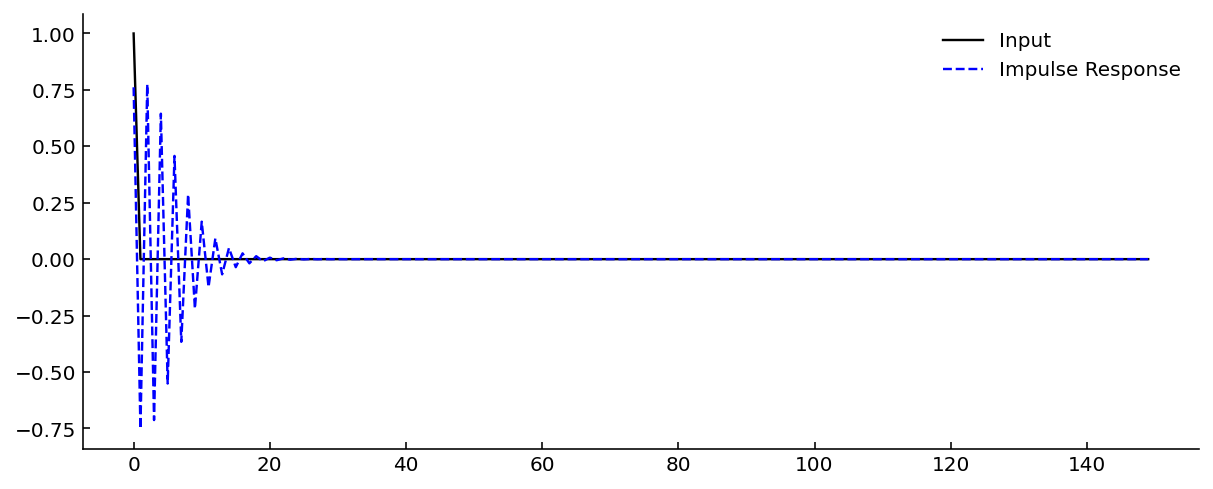

In [141]:
input = signal.unit_impulse(seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
stylize_axes(ax)
ax.plot(input, label="Input", color="black", linewidth=1.2)
ax.plot(output, label="Impulse Response", color="blue", linestyle="--", linewidth=1.2)
ax.legend(loc="upper right", frameon=False)
plt.show()

### Gaussian Noise

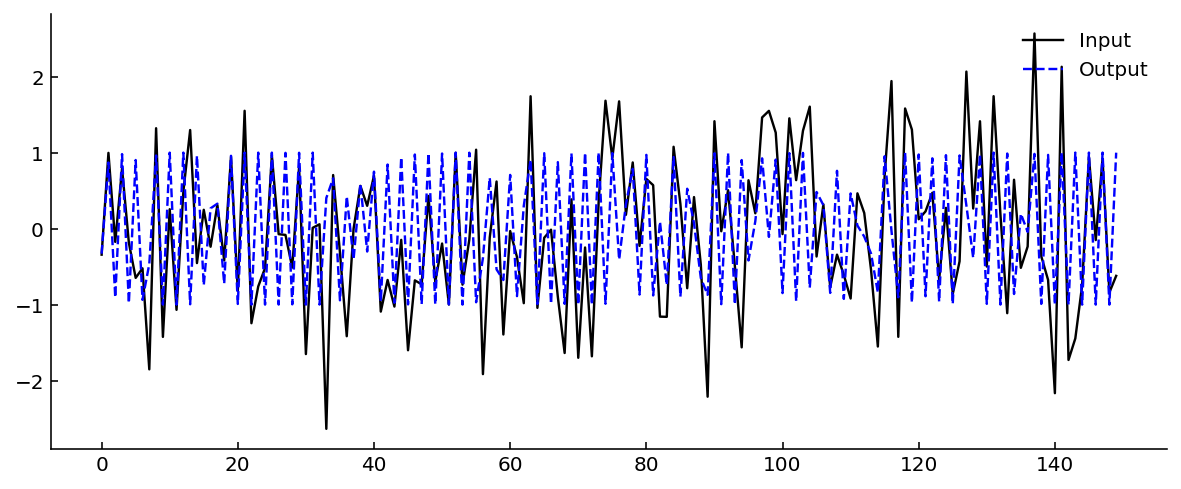

In [142]:
input = np.random.normal(0, 1, size=seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
stylize_axes(ax)
ax.plot(input, label="Input", color="black", linewidth=1.2)
ax.plot(output, label="Output", color="blue", linestyle="--", linewidth=1.2)
ax.legend(loc="upper right", frameon=False)
plt.show()

## Define Recurrent Neural Network Model


In [143]:
import torch
from torch import nn

class RNNLayer(nn.Module):
    """Linear RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
                if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.i2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [144]:
import cmath
import matplotlib.pyplot as plt

def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    rea = [n.real for n in eW]
    imag = [n.imag for n in eW]
    return rea, imag

def polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt, realW_filter=[], imagW_filter=[]):
    fig = plt.figure(figsize=(12,12))

    theta, r = [], []
    for i,j in zip(real_poles, imag_poles):
        r_c, theta_c = cmath.polar(complex(i, j))
        r.append(r_c)
        theta.append(theta_c)

    r_bptt, theta_bptt = [], []
    for i,j in zip(realW_bptt, imagW_bptt):
        r_c, theta_c = cmath.polar(complex(i, j))
        r_bptt.append(r_c)
        theta_bptt.append(theta_c)
    
    if realW_filter is not None:
        r_filter, theta_filter = [], []
        for i,j in zip(realW_filter, imagW_filter):
            r_c, theta_c = cmath.polar(complex(i, j))
            r_filter.append(r_c)
            theta_filter.append(theta_c)

    ax = fig.add_subplot(121, projection='polar')
    ax.scatter(theta, r, color='black', marker='x', label='Poles')
    ax.scatter(theta_bptt, r_bptt, color='red', marker='.', label='RNN Eigenvalues')
    if realW_filter is not None:
        ax.scatter(theta_filter, r_filter, color='blue', marker='.', label='Filter Eigenvalues')
    ax.set_rmax(1)
    ax.set_rticks([0.25, 0.5, 0.75, 1])    # Less radial ticks
    ax.set_rlabel_position(-22.5)          # Move radial labels away from plotted line
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.2, -0.05), loc="center right", frameon=False)
    plt.show()  

In [145]:
from matplotlib.animation import FuncAnimation

def return_polar_form(real, imag):
    r, theta = [], []
    for i,j in zip(real,imag):
        r_c, theta_c = cmath.polar(complex(i, j))
        r.append(r_c)
        theta.append(theta_c)
    return theta, r

def plot_polar_animation(real_poles, imag_poles, real_spectra_network_bptt_biased, imag_spectra_network_bptt_biased, realW_filter, imagW_filter, frames):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='polar')

    sc_poles = ax.scatter(*return_polar_form(real_poles, imag_poles), color='black', marker='x', label='Poles')
    sc_filter = ax.scatter([], [], color='blue', marker='.', label='Filter Eigenvalues')
    sc_bptt = ax.scatter([], [], color='red', marker='.', label='RNN Eigenvalues')

    # Update the frames based on the parameter i
    def animate(i):
        fig.suptitle(f'Epoch {i}')
        theta_filter, r_filter = return_polar_form(realW_filter[i], imagW_filter[i])
        sc_filter.set_offsets(np.c_[theta_filter, r_filter])

        theta, r = return_polar_form(real_spectra_network_bptt_biased[i], imag_spectra_network_bptt_biased[i])
        sc_bptt.set_offsets(np.c_[theta, r])
    
    ax.set_rmax(1)
    ax.set_rticks([0.25, 0.5, 0.75, 1])  # Less radial ticks
    ax.set_rlabel_position(-22.5)        # Move radial labels away from plotted line
    ax.grid(ls='--', lw=0.8)

    ax.legend(bbox_to_anchor=(1.2, -0.05), loc="center right", frameon=False)

    animation = FuncAnimation(fig, animate, interval=200, frames=range(frames))
    animation.save('polar_plot_animation.gif', writer='pillow')

In [146]:
# Instantiate Model
net = RNNNet(1, N, 1)

# Shifted diagonal matrix and IIR filter coefficients
a_copy = -a
a_copy[0] = 1
h2h = torch.diag(torch.ones(N-1), diagonal=-1)
h2h[0,:] = torch.from_numpy(a_copy[1:])
net.rnn.h2h.weight = nn.Parameter(h2h)

# Vector with a "1" for input x
i2h = torch.zeros((N,1))
i2h[0,0] = torch.tensor(1.0)
net.rnn.i2h.weight = nn.Parameter(i2h)

# Weight for linear output layer to select h[0]
fc = torch.zeros((1,N))
fc[0][0] = torch.tensor(1.0)
net.fc.weight = nn.Parameter(fc)

# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)
pred, rnn_output = net(test_inp)

# Compute Loss
criterion = nn.MSELoss()
loss_optimal = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_optimal)

0.39293966


## Train the RNN

In [147]:
net_trained = RNNNet(1, hidden_size, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_trained.parameters(), lr=0.01)

loss_train = []
epochs = 5000
for epoch in range(epochs):
    # Zero the gradient buffer
    optimizer.zero_grad()
    
    # Forward pass
    train_inp = torch.from_numpy(train_X).type(torch.float)
    train_out = torch.from_numpy(train_Y).type(torch.float)

    pred, _ = net_trained(train_inp)

    # Measure the loss
    loss = criterion(pred[:,wash_out:,:], train_out[:,wash_out:,:])
    loss_train.append(loss.data.item())

    # Print the loss
    if epoch%50==0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 0.7664661407470703
50 0.18241463601589203
100 0.10315366089344025
150 0.06410392373800278
200 0.031867168843746185
250 0.02027423121035099
300 0.016010131686925888
350 0.013024014420807362
400 0.010853715240955353
450 0.009258782491087914
500 0.008061395026743412
550 0.00713262939825654
600 0.006379314698278904
650 0.00573352538049221
700 0.005708899348974228
750 0.004662313032895327
800 0.00415563490241766
850 0.003653185907751322
900 0.003207668662071228
950 0.0027760022785514593
1000 0.004291432909667492
1050 0.0021543451584875584
1100 0.0019158588256686926
1150 0.0017403687816113234
1200 0.0016528822015970945
1250 0.001513335038907826
1300 0.001418981933966279
1350 0.0015936772106215358
1400 0.0012822297867387533
1450 0.001214583870023489
1500 0.0012443811865523458
1550 0.001116006402298808
1600 0.0018124254420399666
1650 0.0010387703077867627
1700 0.001158397295512259
1750 0.0009651815635152161
1800 0.0009369225008413196
1850 0.0017617765115574002
1900 0.0008840493974275887
1950

In [148]:
def plot_loss_history(loss_train, loss_test, loss_optimal):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.loglog(loss_train, color='blue', label ="BPTT Train", linewidth=1.2)
    ax.loglog(loss_test*np.ones(epochs), color='black', label ="BPTT Test", linewidth=1.2)
    if loss_optimal is not None:
        ax.loglog(loss_optimal*np.ones(epochs), color='green', label ="Optimal")
    stylize_axes(ax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right", frameon=False)
    plt.show()

0.00043977707


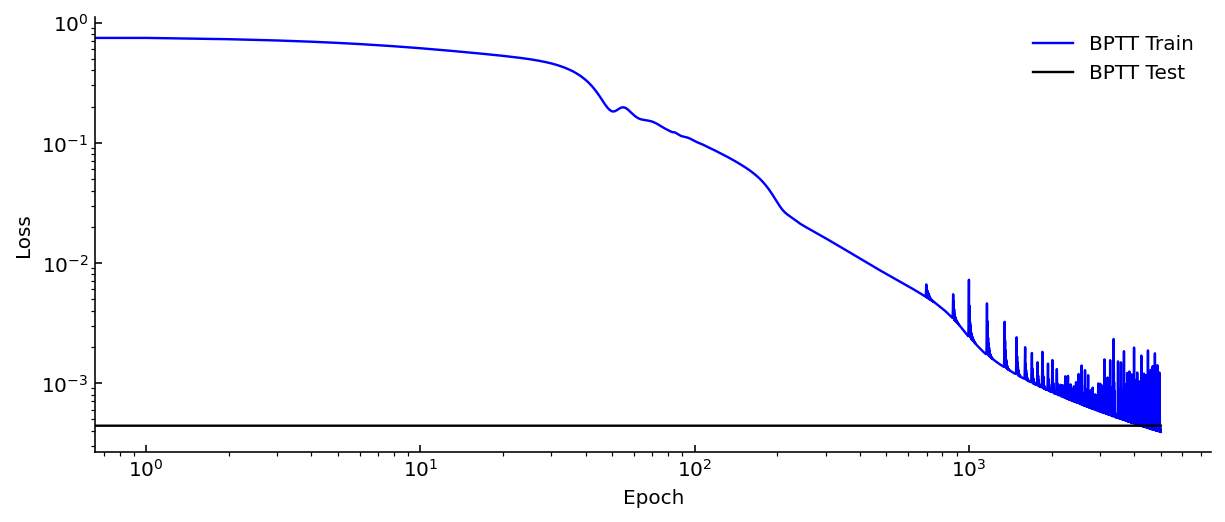

In [149]:
# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)

test_inp.requires_grad = True
test_out.requires_grad = True

pred, rnn_output = net_trained(test_inp)

# Compute Loss
loss_test = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_test)

plot_loss_history(loss_train, loss_test, None)

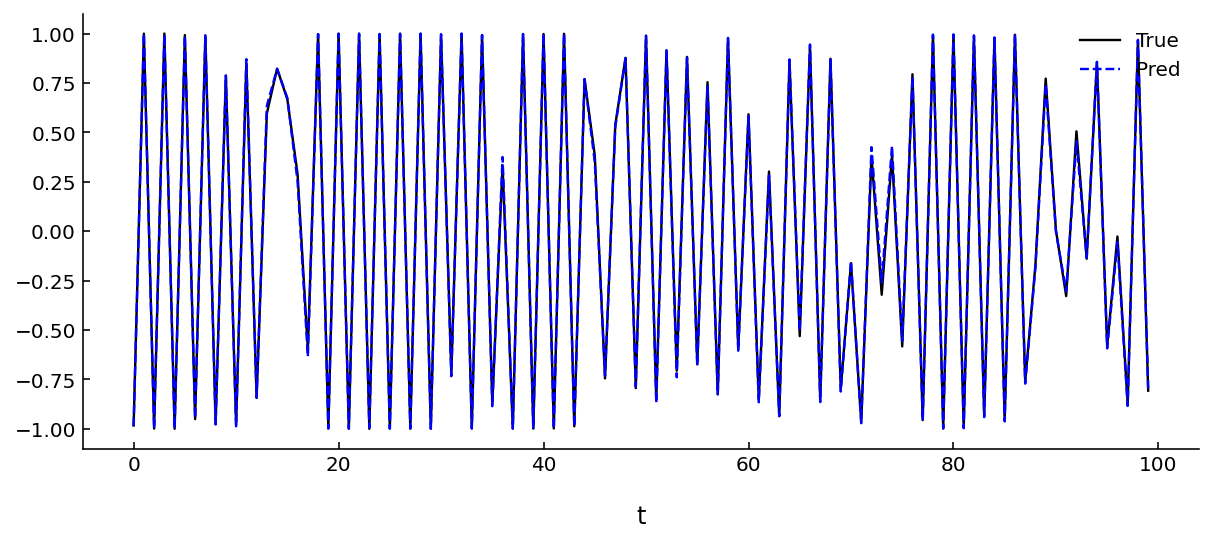

In [150]:
def plot_time_series(true, pred):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    stylize_axes(ax)
    ax.plot(true, label="True", linestyle='solid', color='black', linewidth=1.2)
    ax.plot(pred, label="Pred", linestyle='dashed', color='blue', linewidth=1.2)
    ax.set_xlabel("t", fontsize=12, labelpad=15)
    ax.legend(loc="upper right", frameon=False)
    plt.show()

index_to_plot = 0
plot_time_series(test_out[wash_out:,index_to_plot,0].detach().numpy(), pred[wash_out:,index_to_plot,0].detach().numpy())

## Extract the Lyapunov Exponents

Lyapunov exponent or Lyapunov characteristic exponent of a dynamical system is a quantity that characterizes the rate of separation of infinitesimally close trajectories.

<img src="figures/stability-and-chaos.png" width="700">

Lyapunov spectrum is given by the log of eigenvalues of Oseledets matrix
$$\large
\Lambda = \lim_{t\to\infty} [T_t^T T_t]^{1/2t}
$$

The analytical approximation of which is given by the long-term Jacobian product of non-commuting matrices
$$\large
T_t(h_0) = D_{t-1}(h_{t-1})...D_1(h-1)D_0(h_0)
$$

This is done by unrolling the network dynamics in time
$$\normalsize
\begin{align*}
    \frac{\partial L_t}{\partial W} &= \frac{\partial L_t}{\partial y_t}\frac{\partial y_t}{\partial h_t}\frac{\partial h_t}{\partial W} 
    \\
    &= \frac{\partial L_t}{\partial y_t}\frac{\partial y_t}{\partial h_t}
    \bigg[
        \frac{\partial^+ h_t}{\partial W} + \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial^+h_{t-1}}{\partial W} + ... T_{t-1}(t)\frac{\partial^+ h_1}{\partial W}
    \bigg]
    \\
   T_t(t) &= \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial h_{t-2}}...\frac{\partial h_{t-\tau+1}}{\partial h_{t-\tau}}
\end{align*}
$$

The RNN update equation is given by,

$$\large
h_t=tanh(W_{ih}\cdot  x_t+b_{ih}+W_{hh}\cdot h_{t−1}+b_{hh})$$

where the Jacobian is given by,

$$\normalsize
\begin{align*}
\frac{\partial h_{t+1,i}}{\partial h_{t,j}} &= w_{i,j} (1-tanh^2(h_{t+1,i})) \\
\frac{\partial h_{t+1}}{\partial h_t} &= W_{hh} diag(1-tanh^2(h_{t+1}))
\end{align*}
$$

Since pre-multiplying a matrix $A$ by a diagonal matrix $diag(k)$ is equivalent to scaling up row $i$ of matrix $A$ by $k$

In [182]:
spectral_radii = []

def spectral_normalization(W, threshold=0.9):
    eigen_values = torch.linalg.eigvals(W)
    spectral_radius = max(abs(eigen_values))
    spectral_radii.append(spectral_radius)
    if spectral_radius > threshold:
        W = W/max(abs(eigen_values))
    return W

def oneStepVarQR(J, Q):
    Z = torch.matmul(torch.transpose(J, 1, 2), Q) #Linear extrapolation of the network in many directions
    q, r = torch.qr(Z, some = True) #QR decomposition of new directions
    s = torch.diag_embed(torch.sign(torch.diagonal(r, dim1 = 1, dim2 = 2)))#extract sign of each leading r value
    return torch.matmul(q, s), torch.diagonal(torch.matmul(s, r), dim1 = 1, dim2 = 2) #return positive r values and corresponding vectors

def jacobian(net, x, rnn_state):
    """Compute the Jacobian of an RNN state vector h(t+1) with respect to h(t) for each t."""
    jac_stacked = []
    jac_cumulative = []
    # exponents_vec = []

    hidden = rnn_state[-1]

    feed_seq = x.shape[0]
    num_lyaps = rnn_state.shape[2]

    delta = torch.eye(num_lyaps)

    for t in range(feed_seq):
        hidden = net.rnn.recurrence(x[t], hidden)
        W_hh = net.rnn.h2h.weight
        W_diag = torch.diag(1-torch.tanh(torch.pow(torch.flatten(hidden),2)))

        jac_t = torch.matmul(W_hh, W_diag)  # [N, N]
        jac_stacked.append(jac_t)
        
        delta = torch.matmul(jac_t, delta)  # [N, N]
        jac_cumulative.append(delta)

        # J = spectral_normalization(delta)
        # Q, _ = torch.qr(J, some = True)
        # Q, rvals = oneStepVarQR(J, Q)
        # exponents = torch.sum(torch.log2(rvals.detach()), dim = 1)/feed_seq
        # exponents_vec.append(exponents))

    # Stack together output from all time steps
    return torch.stack(jac_stacked), torch.stack(jac_cumulative)

In [183]:
feed_seq = 100

# Long-term Jacobian for the filter coefficients
_, rnn_state = net(test_inp[0:wash_out,0:1,:])
jac_stacked_filter, jac_cumulative_filter = jacobian(net_trained, test_inp[wash_out:wash_out+feed_seq,0:1,:], rnn_state)

# Long-term Jacobian for the bptt-rnn
_, rnn_state = net_trained(test_inp[0:wash_out,0:1,:])
jac_stacked_bptt, jac_cumulative_bptt = jacobian(net_trained, test_inp[wash_out:wash_out+feed_seq,0:1,:], rnn_state)

In [187]:
# Extract Lyapunov exponents
def extract_lyapunov_exponents(J):
    return NotImplemented

J = np.log(jac_cumulative_filter[-1].detach().numpy())/feed_seq
realW_filter, imagW_filter = extract_eigen_values(J)
realW_bptt, imagW_bptt = extract_eigen_values(jac_cumulative_bptt[-1].detach().numpy())

/var/folders/6w/ywqj47ms7qg5z1dw2v9m4_380000gn/T/ipykernel_993/1913391977.py:5: RuntimeWarning: invalid value encountered in log
  J = np.log(jac_cumulative_filter[-1].detach().numpy())/feed_seq


In [ ]:
# Compare the salient eigenvalues
real_poles, imag_poles = [x.real for x in p], [x.imag for x in p]
polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt, realW_filter, imagW_filter)

### Visualize the eigenvalue drift cross timesteps

In [ ]:
realW_filter, imagW_filter = extract_eigen_values(jac_stacked_filter.detach().numpy())
realW_bptt, imagW_bptt = extract_eigen_values(jac_stacked_bptt.detach().numpy())

plot_polar_animation(real_poles, imag_poles, realW_bptt, imagW_bptt, realW_filter, imagW_filter, feed_seq)

# Supplementary Material

## Compare against Target FT

In [ ]:
from scipy import fftpack

fft = fftpack.fft(output)

amplitude = abs(fft)
power = amplitude**2
angle = np.angle(fft)

peak_amplitude_index = np.argmax(abs(fft))

sample_freq = fftpack.fftfreq(len(output), d=1/seq_len)
peak_amplitude_freq = sample_freq[peak_amplitude_index]

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(sample_freq, abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
print(realW_bptt, imagW_bptt)
print(imagW_bptt[0]/(2*np.pi))